In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import glob
from joblib import load
from sklearn.metrics import r2_score

/home/stefan/.conda/envs/pts/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# look at stats

In [4]:
# we only include the anonomysed set as agreed with the data owners

df_train = pd.read_csv("../nfi-data/train_split.csv")
df_val = pd.read_csv("../nfi-data/val_split.csv")
df_test = pd.read_csv("../nfi-data/test_split.csv")

In [5]:
df_train.eval("temp_diff_years = temp_diff_days / 365", inplace=True)
df_val.eval("temp_diff_years = temp_diff_days / 365", inplace=True)
df_test.eval("temp_diff_years = temp_diff_days / 365", inplace=True)

In [6]:
len(df_val)

919

In [7]:
variable_list = [
    "h_mean_1_",
    "h_mean_2_",
    "h_std_1_",
    "h_std_2_",
    "h_coov_1_",
    "h_coov_2_",
    "h_kur_1_",
    "h_kur_2_",
    "h_skew_1_",
    "h_skew_2_",
    "IR_",
    *[f"h_q{i}_1_" for i in [5, 10, 25, 50, 75, 90, 95, 99]],
    *[f"h_q{i}_2_" for i in [5, 10, 25, 50, 75, 90, 95, 99]],
    "temp_diff_years"
]

In [8]:
target_list = ["BMag_ha", "V_ha"]

In [9]:
df_val[variable_list].describe()

,h_mean_1_,h_mean_2_,h_std_1_,h_std_2_,h_coov_1_,h_coov_2_,h_kur_1_,h_kur_2_,h_skew_1_,h_skew_2_,...,h_q99_1_,h_q5_2_,h_q10_2_,h_q25_2_,h_q50_2_,h_q75_2_,h_q90_2_,h_q95_2_,h_q99_2_,temp_diff_years
count,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,...,919.000000,919.000000,919.000000,919.000000,919.00000,919.000000,919.000000,919.000000,919.000000,919.000000
mean,7.756886,10.737537,5.021482,3.619087,1.067221,0.382178,22.067038,2.080255,0.551701,-0.235734,...,16.771935,4.393771,5.840024,8.442274,11.08420,13.304094,15.007245,15.913966,17.312287,-0.070031
std,5.650914,5.826700,2.618811,1.775645,1.104352,0.218708,280.693397,14.606087,4.220633,1.242230,...,7.569541,3.862539,4.677638,5.669329,6.37934,6.791960,7.077031,7.250701,7.457928,0.555424
min,-0.024825,1.112857,0.053250,0.087785,-4.656972,0.069645,-1.926685,-2.000000,-13.816676,-3.078436,...,0.070000,1.010000,1.020000,1.030000,1.07500,1.150000,1.197000,1.252500,1.330500,-1.000000
25%,3.179662,6.239891,3.099313,2.383729,0.535194,0.262913,-1.173350,-0.621735,-0.683866,-0.871200,...,11.371750,1.590000,2.185000,3.743750,6.01250,8.045000,9.776000,10.440000,11.883950,-0.613699
50%,6.672952,9.647054,4.635112,3.401080,0.798720,0.354456,-0.470218,-0.028935,0.003507,-0.356868,...,16.860200,2.865000,4.172000,7.060000,9.95000,12.360000,14.560000,15.696500,17.290000,0.068493
75%,11.129150,14.899706,6.880495,4.625316,1.197607,0.444563,1.494342,1.175310,0.886396,0.223805,...,22.560900,5.934000,8.335000,12.132500,15.76000,18.273750,20.246000,21.307000,22.789950,0.410959
max,26.873604,28.328451,15.993492,14.319471,13.515706,2.933647,5577.448026,253.406503,68.145993,12.024318,...,44.660000,21.680000,24.490000,27.530000,29.80500,37.080000,40.994000,42.590000,46.510000,0.936986


In [10]:
df_val[target_list].describe()

,BMag_ha,V_ha
count,919.000000,919.000000
mean,112.378628,210.213042
std,105.828078,195.837800
min,0.000000,0.000000
25%,29.292855,52.422856
50%,86.551500,154.638388
75%,165.194985,325.370432
max,668.081976,1176.918249


array([<AxesSubplot: ylabel='Frequency'>,
       <AxesSubplot: ylabel='Frequency'>], dtype=object)

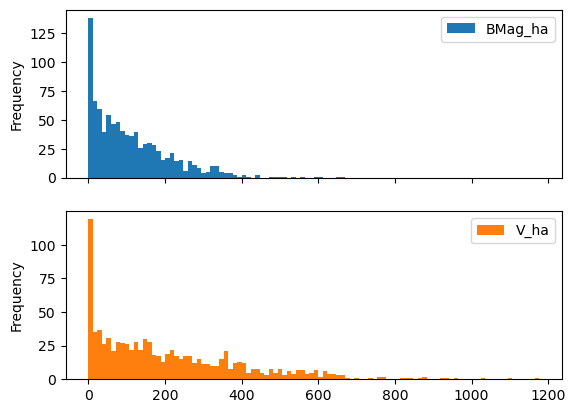

In [11]:
df_val[target_list].plot.hist(bins=100, subplots=True)

In [12]:
X_train = df_train[variable_list + target_list ]
X_val = df_val[variable_list + target_list]
X_test = df_test[variable_list + target_list ]

In [13]:
def rmse_loss(x, y):
    return ((x-y)**2).mean()**.5

## linear model with sklearn

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

In [15]:
# pure linear model
X_trainval = X_train.append(X_val)

imputer = SimpleImputer().fit(X_trainval[variable_list])
X_train_ = imputer.transform(X_trainval[variable_list])
model = LinearRegression().fit(
    X_train_, 
    X_trainval[target_list]
)
y_pred = model.predict(imputer.transform(X_test[variable_list]))
y_pred = np.clip(y_pred, a_min=0, a_max=None)
rmse = []
r2 = []
for i, name in enumerate(target_list):
    rmse.append(rmse_loss(X_test[target_list[i]], y_pred[:, i]))
    r2.append(r2_score(X_test[target_list[i]], y_pred[:, i]))
    
print(f"RMSE:")
[print(f"\t{target}: {score:.3f}") for target, score in zip(target_list, rmse)]
       
print(f"R2 score:")
[print(f"\t{target}: {score:.3f}") for target, score in zip(target_list, r2)]

RMSE:
	BMag_ha: 51.999
	V_ha: 96.744
R2 score:
	BMag_ha: 0.742
	V_ha: 0.747


/tmp/ipykernel_10413/256522388.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_trainval = X_train.append(X_val)


[None, None]

In [16]:
y_pred_train = model.predict(imputer.transform(X_train[variable_list]))
# np.savetxt("linreg_train.csv", y_pred_train)

y_pred_val = model.predict(imputer.transform(X_val[variable_list]))
# np.savetxt("linreg_val.csv", y_pred_val)

y_pred_test = model.predict(imputer.transform(X_test[variable_list]))
# np.savetxt("linreg_test.csv", y_pred_test)

In [17]:
y_pred_val = np.clip(y_pred_val, a_min=0, a_max=None)
rmse = []
r2 = []
for i, name in enumerate(target_list):
    rmse.append(rmse_loss(X_val[target_list[i]], y_pred_val[:, i]))
    r2.append(r2_score(X_val[target_list[i]], y_pred_val[:, i]))

print(f"RMSE:")
[print(f"\t{target}: {score:.3f}") for target, score in zip(target_list, rmse)]
       
print(f"R2 score:")
[print(f"\t{target}: {score:.3f}") for target, score in zip(target_list, r2)]

RMSE:
	BMag_ha: 54.368
	V_ha: 95.053
R2 score:
	BMag_ha: 0.736
	V_ha: 0.764


[None, None]

## RF with sklearn

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
imputer = SimpleImputer(strategy="constant", fill_value=-100).fit(X_trainval[variable_list])

In [20]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    # Number of features to consider at every split
   'max_features': np.arange(0.1, 1.1, 0.1),
    # depth of tree (None means full depth)
   'max_depth': list(np.arange(5, 21)) + [None],
    # Minimum number of samples required at each leaf node
   'min_samples_leaf': [1] + list(np.arange(2, 17, 2)),
    # Method of selecting samples for training each tree
    "max_samples": np.arange(0.1, 1.1, 0.1),
   'bootstrap': [True],
}
pgrid = ParameterGrid(param_grid)

In [ ]:
from tqdm.auto import tqdm
best_score = -np.inf
best_p = {}
best_rf = None
pbar = tqdm(pgrid)
for p in pbar:
    pbar.set_postfix_str(str(p))
    pbar.refresh()
    rf = RandomForestRegressor(1000, n_jobs=-1, oob_score=True, **p).fit(
        imputer.transform(X_trainval[variable_list]), 
        X_trainval[target_list]
    )
    if rf.oob_score_ > best_score:
        best_score = rf.oob_score_
        best_p = p
        best_rf = rf

In [ ]:
# print(f"best params: {best_p}")

In [22]:
best_p = {'bootstrap': True, 'max_depth': 11, 'max_features': 0.9, 'max_samples': 0.2, 'min_samples_leaf': 6}

In [23]:
best_rf = RandomForestRegressor(5000, n_jobs=-1, oob_score=True, **best_p).fit(
    imputer.transform(X_trainval[variable_list]), 
    X_trainval[target_list]
)

In [24]:
y_pred = best_rf.predict(imputer.transform(X_val[variable_list]))
y_pred = np.clip(y_pred, a_min=0, a_max=None)
rmse = []
r2 = []
for i, name in enumerate(target_list):
    rmse.append(rmse_loss(X_val[target_list[i]], y_pred[:, i]))
    r2.append(r2_score(X_val[target_list[i]], y_pred[:, i]))
print(f"RMSE:")
[print(f"\t{target}: {score:.3f}") for target, score in zip(target_list, rmse)]
       
print(f"R2 score:")
[print(f"\t{target}: {score:.3f}") for target, score in zip(target_list, r2)]

RMSE:
	BMag_ha: 50.176
	V_ha: 87.487
R2 score:
	BMag_ha: 0.775
	V_ha: 0.800


[None, None]

In [26]:
# np.savetxt("rf_val.csv", y_pred)